In [1]:
# Imports
import numpy as np
from typing import List, Dict, Tuple, Union
from numpy.typing import ArrayLike

class NeuralNetwork:
    """
    This is a class that generates a fully-connected neural network.

    Parameters:
        nn_arch: List[Dict[str, float]]
            A list of dictionaries describing the layers of the neural network.
            e.g. [{'input_dim': 64, 'output_dim': 32, 'activation': 'relu'}, {'input_dim': 32, 'output_dim': 8, 'activation:': 'sigmoid'}]
            will generate a two-layer deep network with an input dimension of 64, a 32 dimension hidden layer, and an 8 dimensional output.
        lr: float
            Learning rate (alpha).
        seed: int
            Random seed to ensure reproducibility.
        batch_size: int
            Size of mini-batches used for training.
        epochs: int
            Max number of epochs for training.
        loss_function: str
            Name of loss function.

    Attributes:
        arch: list of dicts
            (see nn_arch above)
    """

    def __init__(
        self,
        #got TypeError, changed Union(int, str) to Union[int, str]
        nn_arch: List[Dict[str, Union[int, str]]],
        lr: float,
        seed: int,
        batch_size: int,
        epochs: int,
        loss_function: str
    ):

        # Save architecture
        self.arch = nn_arch

        # Save hyperparameters
        self._lr = lr
        self._seed = seed
        self._epochs = epochs
        self._loss_func = loss_function
        self._batch_size = batch_size

        # Initialize the parameter dictionary for use in training
        self._param_dict = self._init_params()

    def _init_params(self) -> Dict[str, ArrayLike]:
        """
        DO NOT MODIFY THIS METHOD! IT IS ALREADY COMPLETE!

        This method generates the parameter matrices for all layers of
        the neural network. This function returns the param_dict after
        initialization.

        Returns:
            param_dict: Dict[str, ArrayLike]
                Dictionary of parameters in neural network.
        """

        # Seed NumPy
        np.random.seed(self._seed)

        # Define parameter dictionary
        param_dict = {}

        # Initialize each layer's weight matrices (W) and bias matrices (b)
        for idx, layer in enumerate(self.arch):
            layer_idx = idx + 1
            input_dim = layer['input_dim']
            output_dim = layer['output_dim']
            param_dict['W' + str(layer_idx)] = np.random.randn(output_dim, input_dim) * 0.1
            param_dict['b' + str(layer_idx)] = np.random.randn(output_dim, 1) * 0.1

        return param_dict

    def _single_forward(
        self,
        W_curr: ArrayLike,
        b_curr: ArrayLike,
        A_prev: ArrayLike,
        activation: str
    ) -> Tuple[ArrayLike, ArrayLike]:
        """
        This method is used for a single forward pass on a single layer.

        Args:
            W_curr: ArrayLike
                Current layer weight matrix.
            b_curr: ArrayLike
                Current layer bias matrix.
            A_prev: ArrayLike
                Previous layer activation matrix.
            activation: str
                Name of activation function for current layer.

        Returns:
            A_curr: ArrayLike
                Current layer activation matrix.
            Z_curr: ArrayLike
                Current layer linear transformed matrix.
        """
        #Apply linear transofrm to previous activation layer (z(l+1) = w(l)a(l) + b(l))
        Z_curr = np.dot(A_prev, W_curr.T) + b_curr.T

        #Apply activation function to activation matrix for next layer
        if activation == "relu":
            A_curr = self._relu(Z_curr)
        elif activation == "sigmoid":
            A_curr = self._sigmoid(Z_curr)
        else:
            raise ValueError("Activation function is neither relu or sigmoid")
        
        return A_curr, Z_curr

    def forward(self, X: ArrayLike) -> Tuple[ArrayLike, Dict[str, ArrayLike]]:
        """
        This method is responsible for one forward pass of the entire neural network.

        Args:
            X: ArrayLike
                Input matrix with shape [batch_size, features].

        Returns:
            output: ArrayLike
                Output of forward pass.
            cache: Dict[str, ArrayLike]:
                Dictionary storing Z and A matrices from `_single_forward` for use in backprop.
        """
        #Initialize empty cache dict, previous activaiton matrix, and add it to cache
        cache = {}
        cache['A0'] = X
        A_prev = X

        #Iterate through network and pull out weights and bias from each layer
        for idx, layer in enumerate(self.arch):
            layer_idx = idx + 1

            #Get current weights, bias, and activation
            W_curr = self._param_dict['W' + str(layer_idx)]
            b_curr = self._param_dict['b' + str(layer_idx)]
            activation = layer['activation']

            #Single forward pass to get activation matrix and linearly transformed matrix
            A_curr, Z_curr = self._single_forward(W_curr, b_curr, A_prev, activation)
            
            #Store A_curr matrix and Z_curr matrix in cache
            cache["A" + str(layer_idx)] = A_curr
            cache["Z" + str(layer_idx)] = Z_curr

            #Set A_curr to be A_prev for next loop
            A_prev = A_curr
        
        #return final activation matrix and cache
        return A_prev, cache

    def _single_backprop(
        self,
        W_curr: ArrayLike,
        b_curr: ArrayLike,
        Z_curr: ArrayLike,
        A_prev: ArrayLike,
        dA_curr: ArrayLike,
        activation_curr: str
    ) -> Tuple[ArrayLike, ArrayLike, ArrayLike]:
        """
        This method is used for a single backprop pass on a single layer.

        Args:
            W_curr: ArrayLike
                Current layer weight matrix.
            b_curr: ArrayLike
                Current layer bias matrix.
            Z_curr: ArrayLike
                Current layer linear transform matrix.
            A_prev: ArrayLike
                Previous layer activation matrix.
            dA_curr: ArrayLike
                Partial derivative of loss function with respect to current layer activation matrix.
            activation_curr: str
                Name of activation function of layer.

        Returns:
            dA_prev: ArrayLike
                Partial derivative of loss function with respect to previous layer activation matrix.
            dW_curr: ArrayLike
                Partial derivative of loss function with respect to current layer weight matrix.
            db_curr: ArrayLike
                Partial derivative of loss function with respect to current layer bias matrix.
        """
        #Backprop based on current layer activation
        if activation_curr == "relu":
            dZ_curr = self._relu_backprop(dA_curr, Z_curr)
        elif activation_curr == "sigmoid":
            dZ_curr = self._sigmoid_backprop(dA_curr, Z_curr)
        else:
            raise ValueError("Activation function is neither relu nor sigmoid")
        
        #number observations m to divide 1/m
        #m = A_prev.shape[1]


        #Calculate partial derivatives
        dA_prev = np.dot(dZ_curr, W_curr)
        dW_curr = np.dot(dZ_curr.T, A_prev)
        db_curr = np.sum(dZ_curr, axis=0).reshape(b_curr.shape)

        return dA_prev, dW_curr, db_curr


    def backprop(self, y: ArrayLike, y_hat: ArrayLike, cache: Dict[str, ArrayLike]):
        """
        This method is responsible for the backprop of the whole fully connected neural network.

        Args:
            y (array-like):
                Ground truth labels.
            y_hat: ArrayLike
                Predicted output values.
            cache: Dict[str, ArrayLike]
                Dictionary containing the information about the
                most recent forward pass, specifically A and Z matrices.

        Returns:
            grad_dict: Dict[str, ArrayLike]
                Dictionary containing the gradient information from this pass of backprop.
        """
        #init grad_dict
        grad_dict = {}

        #decide what the loss is to backprop from on outermost layer(loss)
        if self._loss_func == "bce":
            dA_curr = self._binary_cross_entropy_backprop(y, y_hat)
        elif self._loss_func == "mse":
            dA_curr = self._mean_squared_error_backprop(y, y_hat)
        else:
            raise ValueError("Invalid loss function. Not bce or mse")
        
        #propagate backwards through the layers, adjust weights via gradient descent
        for idx, layer in reversed(list(enumerate(self.arch))):
            layer_idx = idx + 1
            #get  weights, bias, activation from layer
            activation = layer["activation"]
            W_curr = self._param_dict["W" + str(layer_idx)]
            b_curr = self._param_dict["b" + str(layer_idx)]

            #get Z and previous A matrix from cache
            A_prev = cache["A" + str(idx)]
            Z_curr = cache["Z" + str(layer_idx)]

            #run backprop
            dA_prev, dW_curr, db_curr = self._single_backprop(W_curr, b_curr, Z_curr, A_prev, dA_curr, activation)

            #store gradient values
            grad_dict["dW" + str(layer_idx)] = dW_curr
            grad_dict["db" + str(layer_idx)] = db_curr

            #update activation matrix
            dA_curr = dA_prev

        return grad_dict

    def _update_params(self, grad_dict: Dict[str, ArrayLike]):
        """
        This function updates the parameters in the neural network after backprop. This function
        only modifies internal attributes and does not return anything

        Args:
            grad_dict: Dict[str, ArrayLike]
                Dictionary containing the gradient information from most recent round of backprop.
        """
        #Update weights and bias
        for idx, layer in enumerate(self.arch):
            layer_idx = idx + 1
            #curr W val - (lr *  gradW)
            self._param_dict["W" + str(layer_idx)] = self._param_dict["W" + str(layer_idx)] - (self._lr * grad_dict["dW" + str(layer_idx)])
            #curr b val - (lr *  gradb)
            self._param_dict["b" + str(layer_idx)] = self._param_dict["b" + str(layer_idx)] - (self._lr * grad_dict["db" + str(layer_idx)])
        
        return None

    def fit(
        self,
        X_train: ArrayLike,
        y_train: ArrayLike,
        X_val: ArrayLike,
        y_val: ArrayLike
    ) -> Tuple[List[float], List[float]]:
        """
        This function trains the neural network by backpropagation for the number of epochs defined at
        the initialization of this class instance.

        Args:
            X_train: ArrayLike
                Input features of training set.
            y_train: ArrayLike
                Labels for training set.
            X_val: ArrayLike
                Input features of validation set.
            y_val: ArrayLike
                Labels for validation set.

        Returns:
            per_epoch_loss_train: List[float]
                List of per epoch loss for training set.
            per_epoch_loss_val: List[float]
                List of per epoch loss for validation set.
        """
        #init lists to store losses
        per_epoch_train_loss = []
        per_epoch_val_loss = []

        num_batches = np.ceil(X_train.shape[0] / self._batch_size)

        for epoch in range(self._epochs):
            #shuffle training data
            shuffle = np.random.permutation(X_train.shape[0])
            X_train_shuffle = X_train[shuffle]
            y_train_shuffle = y_train[shuffle]
            #split training into batches
            X_batch = np.array_split(X_train_shuffle, num_batches)
            y_batch = np.array_split(y_train_shuffle, num_batches)

            #init list to keep track of batch train loss per epoch
            batch_train_loss = []
            #iterate through batches and do forward and backward passes
            for X_train_batch, y_train_batch in zip(X_batch, y_batch):
                #forward pass
                y_hat_train, cache_train = self.forward(X_train_batch)
                #calculate losses and add to loss list
                if self._loss_func == "bce":
                    batch_train_loss.append(self._binary_cross_entropy(y_train_batch, y_hat_train))
                else:
                    self._loss_func == "mse"
                    batch_train_loss.append(self._mean_squared_error(y_train_batch, y_hat_train))
                #backpropagation and update params
                grad_dict = self.backprop(y_train_batch, y_hat_train, cache_train)
                self._update_params(grad_dict)
            #get average loss for current epoch and add to list
            per_epoch_train_loss.append(np.mean(batch_train_loss))

            #get validation loss for current epoch
            y_hat_val = self.predict(X_val)
            if self._loss_func == "bce":
                val_loss = self._binary_cross_entropy(y_val, y_hat_val)
            else:
                self._loss_func == "mse"
                val_loss = self._mean_squared_error(y_val, y_hat_val)
            
            per_epoch_val_loss.append(val_loss)
        
        return per_epoch_train_loss, per_epoch_val_loss


    def predict(self, X: ArrayLike) -> ArrayLike:
        """
        This function returns the prediction of the neural network.

        Args:
            X: ArrayLike
                Input data for prediction.

        Returns:
            y_hat: ArrayLike
                Prediction from the model.
        """
        #forward pass
        y_hat, _ = self.forward(X)

        return y_hat

    def _sigmoid(self, Z: ArrayLike) -> ArrayLike:
        """
        Sigmoid activation function.

        Args:
            Z: ArrayLike
                Output of layer linear transform.

        Returns:
            nl_transform: ArrayLike
                Activation function output.
        """
        nl_transform = 1 / (1 + np.exp(-Z))

        return nl_transform

    def _sigmoid_backprop(self, dA: ArrayLike, Z: ArrayLike):
        """
        Sigmoid derivative for backprop.

        Args:
            dA: ArrayLike
                Partial derivative of previous layer activation matrix.
            Z: ArrayLike
                Output of layer linear transform.

        Returns:
            dZ: ArrayLike
                Partial derivative of current layer Z matrix.
        """
        #f'(z)=f(z)(1−f(z)
        sigmoid_Z = self._sigmoid(Z)
        dZ = sigmoid_Z * (1-sigmoid_Z)

        return dZ * dA #chain rule

    def _relu(self, Z: ArrayLike) -> ArrayLike:
        """
        ReLU activation function.

        Args:
            Z: ArrayLike
                Output of layer linear transform.

        Returns:
            nl_transform: ArrayLike
                Activation function output.
        """
        nl_transform = np.maximum(0,Z)

        return nl_transform

    def _relu_backprop(self, dA: ArrayLike, Z: ArrayLike) -> ArrayLike:
        """
        ReLU derivative for backprop.

        Args:
            dA: ArrayLike
                Partial derivative of previous layer activation matrix.
            Z: ArrayLike
                Output of layer linear transform.

        Returns:
            dZ: ArrayLike
                Partial derivative of current layer Z matrix.
        """
        dZ = np.multiply(dA, np.where(Z > 0, 1, 0))

        return dZ
        

    def _binary_cross_entropy(self, y: ArrayLike, y_hat: ArrayLike) -> float:
        """
        Binary cross entropy loss function.

        Args:
            y_hat: ArrayLike
                Predicted output.
            y: ArrayLike
                Ground truth output.

        Returns:
            loss: float
                Average loss over mini-batch.
        """
        #(-1/N)(sum(y_i * log*y_hat) + ((1-y_i))*(log(1-y_hat)))

        #avoid divide by 0 error by clipping y_hat values
        y_hat = np.clip(y_hat, 1e-6, 1 - 1e-6)

        bce_loss = -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

        return bce_loss

    def _binary_cross_entropy_backprop(self, y: ArrayLike, y_hat: ArrayLike) -> ArrayLike:
        """
        Binary cross entropy loss function derivative for backprop.

        Args:
            y_hat: ArrayLike
                Predicted output.
            y: ArrayLike
                Ground truth output.

        Returns:
            dA: ArrayLike
                partial derivative of loss with respect to A matrix.
        """
        #avoid divide by 0 error by clipping y_hat values
        y_hat = np.clip(y_hat, 1e-6, 1 - 1e-6)

        #chain rule 
        dA = ((1-y)/(1-y_hat)) - (y/y_hat)
        
        return dA


    def _mean_squared_error(self, y: ArrayLike, y_hat: ArrayLike) -> float:
        """
        Mean squared error loss.

        Args:
            y: ArrayLike
                Ground truth output.
            y_hat: ArrayLike
                Predicted output.

        Returns:
            loss: float
                Average loss of mini-batch.
        """
        mse_loss  = np.mean((y - y_hat)**2)
        return mse_loss

    def _mean_squared_error_backprop(self, y: ArrayLike, y_hat: ArrayLike) -> ArrayLike:
        """
        Mean square error loss derivative for backprop.

        Args:
            y_hat: ArrayLike
                Predicted output.
            y: ArrayLike
                Ground truth output.

        Returns:
            dA: ArrayLike
                partial derivative of loss with respect to A matrix.
        """
        # -2/N * (y - y_hat)
        dA = (-2 * (y - y_hat)) / len(y)
        return dA

In [23]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
#Load digits dataset
digits = load_digits()
X, y = digits.data, digits.target

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train.shape, X_test.shape

((1437, 64), (360, 64))

In [17]:
arch = [{'input_dim': 64, 'output_dim': 16, 'activation': 'relu'},
       {'input_dim': 16, 'output_dim': 64, 'activation': 'relu'}]
# initialize autoencoder
model = NeuralNetwork(arch, lr = 0.0001, seed = 42, batch_size = 50, epochs = 500, loss_function = "mse")

In [18]:
# train autoencoder on the training data
train_loss, test_loss = model.fit(X_train, X_train, X_test, X_test)

average Training Error: 6.064917599905919
average Validation Error: 6.416368347717475


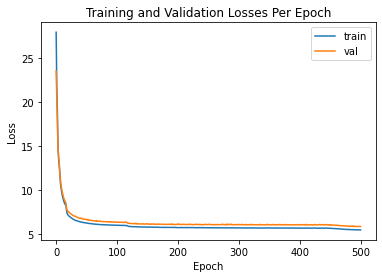

In [19]:
plt.plot(train_loss, label="train")
plt.plot(test_loss, label="val")
plt.title("Training and Validation Losses Per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
print(f'average Training Error: {np.mean(train_loss)}')
print(f'average Validation Error: {np.mean(test_loss)}')

Average prediction error: 5.884491004812239


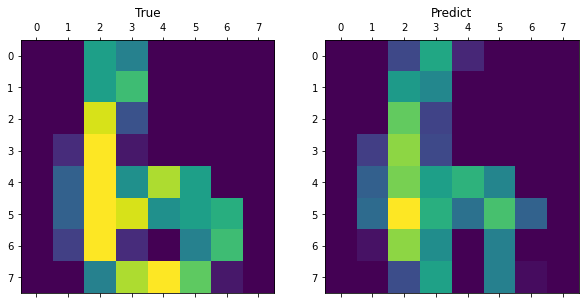

In [28]:
pred = model.predict(X_test)
pred_err = mean_squared_error(X_test, pred)
print("Average prediction error: " + str(pred_err))

fig, ax = plt.subplots(1, 2, figsize = (10, 10))
ax[0].matshow(X_test[3].reshape((8, 8)))
ax[0].set_title("True")
ax[1].matshow(pred[3].reshape((8, 8)))
ax[1].set_title("Predict")
plt.show() 